### Scope: The players roughly approximate all players that would be owned in a 12-team league, hold for some very-deep sleepers. The counts are shown below:
`[('QB', 50), ('RB', 100), ('WR', 150), ('TE', 30), ('D/ST', 32), ('K', 40)]`<br><br>
More details can be found in the `download_projection_data` notebook. 

# Mean Absolute Deviation (MAD)

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

with open('projections_thru_wk_13_ppr.json', 'r') as f:
    recs = json.load(f)

In [2]:
recs = pd.DataFrame(recs)
recs.shape

(5226, 5)

In [3]:
recs.head()

,name,points,projected,position,week
0,Patrick Mahomes,20.44,23.31,QB,1
1,Russell Wilson,31.78,19.81,QB,1
2,Kyler Murray,26.30,18.00,QB,1
3,Josh Allen,28.18,19.84,QB,1
4,Deshaun Watson,20.82,21.95,QB,1


In [4]:
recs = recs.loc[~(recs['projected'] == 0.0)].copy()
recs.shape

(3867, 5)

In [5]:
print('projections available by week')
recs.groupby(by='week').count()['name']

projections available by week


week
1     344
2     331
3     320
4     302
5     283
6     283
7     284
8     276
9     275
10    276
11    281
12    307
13    305
Name: name, dtype: int64

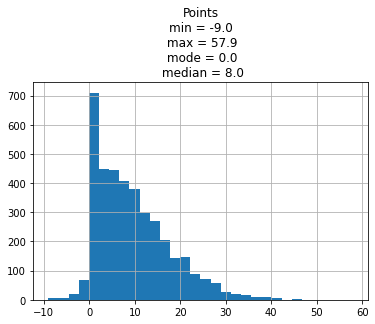

In [6]:
recs.points.hist(bins=30)
plt.title('Points\nmin = {}\n max = {}\n mode = {}\n median = {}'.format(recs.points.min(), recs.points.max(), recs.points.mode()[0], recs.points.median()))
plt.show()

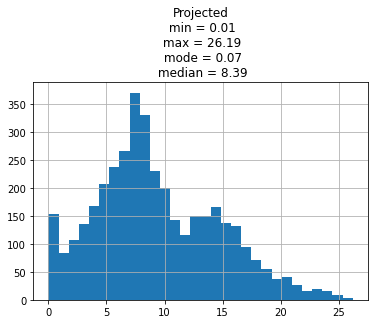

In [7]:
recs.projected.hist(bins=30)
plt.title('Projected\n min = {}\n max = {}\n mode = {}\n median = {}'.format(recs.projected.min(), recs.projected.max(), recs.projected.mode()[0], recs.projected.median()))
plt.show()

In [8]:
recs['prmp'] = recs['projected'] - recs['points']

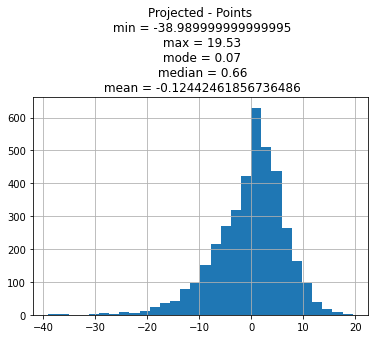

In [9]:
recs.prmp.hist(bins=30)
plt.title('Projected - Points\n min = {}\n max = {}\n mode = {}\n median = {}\n mean = {}'.format(recs.prmp.min(), recs.prmp.max(), recs.prmp.mode()[0], recs.prmp.median(), recs.prmp.mean()))
plt.show()

# Goodness of fit analysis & Regression
Inspired by Steven Morse's Blog Post: Checking ESPN Fantasy Football Projections with Python<br>
https://stmorse.github.io/journal/espn-fantasy-projections.html

In [10]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

$R^2$ from linear regression is the same as when it is derived from correlation

In [12]:
data = recs.loc[recs['position'] == 'K']
pts = data[['projected', 'points']].values
X = pts[:, 0].reshape(-1, 1)
y = pts[:, 1]
reg = LinearRegression().fit(X, y)
reg.score(X, y)
np.round(data[['projected', 'points']].corr().iloc[0, 1]**2, 10) == np.round(reg.score(X, y), 10), \
np.round(data[['projected', 'points']].corr().iloc[0, 1]**2, 10)

(True, 0.0132870993)

$\sqrt{R^2} = r_{xy} = \frac{Cov(X, Y)}{s_X s_y}$

In [13]:
# correlation is covariance normalized by the product of std_x and std_y
np.round((data[['projected', 'points']].cov().iloc[0, 1] / (data['projected'].std() * data['points'].std())), 10) \
    == np.round(data[['projected', 'points']].corr().iloc[0, 1], 10)\
    , np.round(data[['projected', 'points']].corr().iloc[0, 1], 10)

(True, 0.1152696808)

In [14]:
class Stats:
    """Used to check out work.
    Ref https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/"""
    
    def __init__(self, X, y, model):
        self.data = X
        self.target = y
        self.model = model
        ## degrees of freedom population dep. variable variance
        self._dft = X.shape[0] - 1   
        ## degrees of freedom population error variance
        self._dfe = X.shape[0] - X.shape[1] - 1  
    
    def sse(self):
        '''returns sum of squared errors (model vs actual)'''
        squared_errors = (self.target - self.model.predict(self.data)) ** 2
        return np.sum(squared_errors)
        
    def sst(self):
        '''returns total sum of squared errors (actual vs avg(actual))'''
        avg_y = np.mean(self.target)
        squared_errors = (self.target - avg_y) ** 2
        return np.sum(squared_errors)
    
    def r_squared(self):
        '''returns calculated value of r^2'''
        return 1 - self.sse()/self.sst()

$\hat{\beta}_1 = r \frac{s_Y}{s_X}$<br>
$R^2 = \frac{TSS - RSS}{TSS} =$ how much variation in y can be explained by variation in x <br>
$RSS = \sum_{i=1}^n e_i^2$ where $e_i = y_i - \hat{y_i}$ <br>
$TSS = \sigma^2 n$

In [15]:
print('R^2 via correlation', data[['projected', 'points']].corr().iloc[0, 1]**2)

R^2 via correlation 0.013287099301568205


In [17]:
rss = ((pts[:, 1] - pts[:, 0])**2).sum()
print('RSS for y hat = x:', rss)
print('RSS for y hat', Stats(X, y, reg).sse())

RSS for y hat = x: 7725.452
RSS for y hat 7671.690199466189


In [18]:
print('R^2 for y hat = x', 1 - rss/(pts[:, 1].var()*len(pts)))
print('R^2 for y hat', Stats(X, y, reg).r_squared())

R^2 for y hat = x 0.006372395921708129
R^2 for y hat 0.01328709930156824


According to KhanAcademy, "$R^2$ tells us what percent of the prediction error in the y variable is eliminated when we use least-squares regression on the x variable." Per the above, the $R^2$ depends on your definition of $\hat{y}$. Traditionally, $\hat{y_i}$ corresponds to the predicted value using the least squares estimate or the line that maximizes $R^2$. This is also the $\hat{y_i}$ you get when calculating $R^2$ with correlation. <br>

However for our problem, we are keen to know how well the data fits the true line, x=y since our x is trying to directly fit y. While this is not the least-squares regression, our non-OLS $R^2$ tells us what percent of the prediction error in the y variable is eliminated when we use the projections."

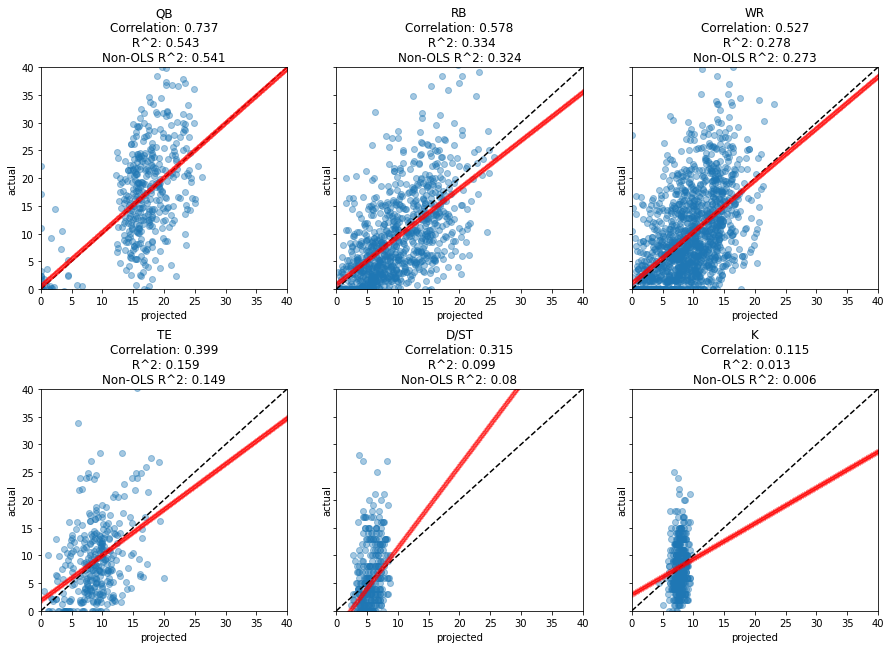

In [19]:
rows = 3
fig, axs = plt.subplots(2, rows, sharey=True, figsize=(15,10))
for i, p in enumerate(['QB', 'RB', 'WR', 'TE', 'D/ST', 'K']):
    data = recs.loc[recs['position'] == p]
    pts = data[['projected', 'points']].values
    r = data[['points', 'projected']].corr().iloc[0, 1]
    r2 = r ** 2
    y_hat_x = pts[:, 0]
    x_r2 = 1- ((pts[:, 1] - y_hat_x)**2).sum() / (pts[:, 1].var()*len(pts))
    X = pts[:, 0].reshape(-1, 1)
    y = pts[:, 1]
    reg = LinearRegression().fit(X, y)
    axs[i//rows][i%rows].plot(np.linspace(0, 50, 1000), np.linspace(0, 50, 1000), 'k--')
    axs[i//rows][i%rows].plot(np.linspace(0, 50, 1000), reg.predict(np.linspace(0, 50, 1000).reshape(-1, 1)), 'r+', alpha=0.25)
    axs[i//rows][i%rows].scatter(data['projected'], data['points'], alpha=0.4)
    axs[i//rows][i%rows].set(xlim=[0, 40], ylim=[0, 40], xlabel='projected', ylabel='actual', 
                             title='{}\nCorrelation: {}\n R^2: {}\nNon-OLS R^2: {}'.format(p, np.round(r, 3), np.round(r2, 3), np.round(x_r2, 3))
                            )
plt.subplots_adjust(hspace=0.45)
plt.show()

### Takeaways:
- QB projections are the strongest with around 54% of the variation in the actual value explained by the projection
  - This is likely explained by their comparatively lower actual score variance: QBs generally have a higher floor and lower ceiling and need to put up more stats for fewer points
- Prediction accuracy is mostly useless aside from being able to know that a player projected to score 20 will do better tha one projected to score 10
- Kicker projections are practially uncorrelated and by that metric, meaningless
- TE accuracy has the lowest $R^2$ of all the flex positions
  - As shown below in the correlation decomposition, TEs have the lowest variance of all the skill positions so this is somewhat surprising
  - A lack of data relative to the other skill positions may account for this
- A similar analysis done by Steven Morse shown below on 2018 shows a very similar trend

In [28]:
print('Correlation decomposition')
for i, p in enumerate(['RB', 'WR', 'TE']):
    data = recs.loc[recs['position'] == p]
    pts = data[['projected', 'points']].values
    print(p, 'actual variance:', np.round(pts[:, 1].var(), 4), ', projection variance', np.round(pts[:, 0].var(), 4), ', covariance', np.round(np.cov(pts)[0][1], 4))

Correlation decomposition
RB actual variance: 65.0897 , projection variance 29.0923 , covariance 1.5207
WR actual variance: 68.355 , projection variance 21.8326 , covariance -13.9815
TE actual variance: 51.942 , projection variance 12.2206 , covariance -0.0548


check out the projection accuracy from 2018: it's nearly the same


[![Foo](https://stmorse.github.io/images/espn_proj_vs_actual.png)](https://stmorse.github.io/images/espn_proj_vs_actual.png)

Source: https://stmorse.github.io/journal/espn-fantasy-projections.html